In [9]:
import sys
sys.path.append('/scratch/ne2213/projects/tmp_packages')
sys.path.append('/scratch/ne2213/projects/tmp_packages/')
import torch
import numpy as np

import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, SubsetRandomSampler
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from efficientnet_pytorch import EfficientNet
import torchvision.transforms.functional as F_t

import warnings
warnings.filterwarnings("ignore")

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import random
import torch.optim.lr_scheduler as lr_scheduler
from torchvision.transforms import ToPILImage

In [10]:
# Set random seed for Python's built-in random module
random_seed = 42
random.seed(random_seed)

# Set random seed for NumPy
np.random.seed(random_seed)

# Set random seed for PyTorch
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

***We define a custom transformation class for normalizing single-channel tensor images, since the Fer2013 dataset consists of gray scale images***

In [11]:
class NormalizeSingleChannel(object):
    def __init__(self, mean, std, inplace=False):
        self.mean = mean
        self.std = std
        self.inplace = inplace

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image to be normalized.

        Returns:
            Tensor: Normalized Tensor image.
        """
        if not isinstance(tensor, torch.Tensor):
            raise TypeError(f"img should be Tensor Image. Got {type(tensor)}")

        if tensor.ndim == 3:  # For single-channel input tensor
            tensor = tensor.unsqueeze(0)  # Add batch dimension

        if tensor.ndim != 4 or tensor.shape[1] != 1:
            raise ValueError("Input tensor shape should be [1, H, W]")

        mean = torch.as_tensor(self.mean, dtype=torch.float32, device=tensor.device)
        std = torch.as_tensor(self.std, dtype=torch.float32, device=tensor.device)

        # Broadcast mean and std to match tensor shape
        mean = mean.view(-1, 1, 1)
        std = std.view(-1, 1, 1)

        if self.inplace:
            tensor.sub_(mean).div_(std)
            return tensor
        else:
            return F_t.normalize(tensor, mean, std, self.inplace)

***We use RandomHorizontalFlip and RandomRotation to perform data augmentation, and then filter the dataset to only use data corresponding to  anger, happiness, or sadness:***

In [12]:
transform = transforms.Compose([
    transforms.Grayscale(),        # Convert images to grayscale
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(degrees=15), 
    transforms.Resize((224, 224)),   # Resize images to 224x224 (or any appropriate size for your model)
    transforms.ToTensor(),         # Convert images to tensors
    transforms.Normalize(mean=[0.485], std=[0.229])  # Normalize images
])

# Load FER2013 dataset
fer2013_df = pd.read_csv('/scratch/ne2213/projects/DL/DL-FinalProject/fer2013.csv')

target_emotions = [0, 3, 4]  # 0: anger, 3: happiness, 4: sadness
filtered_df = fer2013_df[fer2013_df['emotion'].isin(target_emotions)] 

# Define a mapping dictionary
mapping = {0: 0, 3: 1, 4: 2}
# Apply the mapping to the dataset labels
filtered_df['emotion'] = filtered_df['emotion'].map(mapping)


***We create a custom PyTorch dataset from a DataFrame, allowing for easy handling and transformation of the data for training or evaluation***

In [13]:
# Define custom dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.to_pil = ToPILImage()  # Instantiate ToPILImage transformer
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        image = np.array(self.dataframe.iloc[idx, 1].split(), dtype=np.uint8).reshape(48, 48)
        label = int(self.dataframe.iloc[idx, 0])  # No need to subtract 1 from the label

        # Convert NumPy array to PIL Image
        image = self.to_pil(image)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label



# Create custom dataset and apply transformations
custom_dataset = CustomDataset(filtered_df, transform=transform)


In [14]:
# Split dataset into training, validation, and test sets
train_size = int(0.7 * len(custom_dataset))
val_size = int(0.15 * len(custom_dataset))
test_size = len(custom_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    custom_dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

***We use the pretrained EfficientNet-B0 model, and customize it to work on gray scale data, because our dataset Fer2013 is gray scale:*** 

In [15]:
class EfficientNetGray(nn.Module):
    def __init__(self, model_name='efficientnet-b0', num_classes=7):
        super(EfficientNetGray, self).__init__()
        self.model = EfficientNet.from_name(model_name)
        self.model._conv_stem = nn.Conv2d(1, 32, kernel_size=3, stride=2, bias=False)
        num_ftrs = self.model._fc.in_features
        self.model._fc = nn.Linear(num_ftrs, num_classes)
        self.dropout = nn.Dropout(0.5)  # Dropout layer
        self.batch_norm = nn.BatchNorm2d(num_ftrs)  # Batch normalization layer

    def forward(self, x):
        x = self.model.extract_features(x)
        x = self.batch_norm(x)  # Batch normalization after the features are extracted
        x = self.model._avg_pooling(x)
        x = x.flatten(start_dim=1)
        x = self.dropout(x)
        x = self.model._dropout(x)
        x = self.model._fc(x)
        return x

***Next, we initialize the model and define the optimizer, loss function, and learning rate scheduler. Then we train the model for a 100 epochs and compute the training loss and accuracy for each batch. Then we performs backpropagation and optimization, and set the model to evaluation mode and evaluate its performance on the validation dataset, computing validation loss and accuracy. We save the model's state dictionary to use in the next phase of the project***

In [16]:
# Initialize the model
model = EfficientNetGray()
model.to(device)

# Optimizer and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Learning rate scheduler

# Train the model
epochs = 100

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_loss = float('inf')  # Initialize with a high value

for epoch in range(epochs):
    model.train()
    scheduler.step()
    
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
    
    # Save the model if validation loss has decreased
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), 'newest_model_efficientnet.pth')
    
    print(f'Epoch [{epoch+1}/{epochs}], '
          f'Train Loss: {epoch_train_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {epoch_val_loss:.4f}, '
          f'Val Accuracy: {val_accuracy:.4f}')

# Convert lists to numpy arrays
train_losses_np = np.array(train_losses)
val_losses_np = np.array(val_losses)
train_accuracies_np = np.array(train_accuracies)
val_accuracies_np = np.array(val_accuracies)

# Specify paths to save the arrays
train_losses_path = '/scratch/ne2213/projects/DL/DL-FinalProject/newest_train_losses_efficientnet.npy'
val_losses_path = '/scratch/ne2213/projects/DL/DL-FinalProject/newest_val_losses_efficientnet.npy'
train_accuracies_path = '/scratch/ne2213/projects/DL/DL-FinalProject/newest_train_accuracies_efficientnet.npy'
val_accuracies_path = '/scratch/ne2213/projects/DL/DL-FinalProject/newest_val_accuracies_efficientnet.npy'

# Save arrays
np.save(train_losses_path, train_losses_np)
np.save(val_losses_path, val_losses_np)
np.save(train_accuracies_path, train_accuracies_np)
np.save(val_accuracies_path, val_accuracies_np)

print("Arrays saved successfully.")

Epoch [1/100], Train Loss: 1.2821, Train Accuracy: 0.4546, Val Loss: 1.0737, Val Accuracy: 0.4604
Epoch [2/100], Train Loss: 0.8385, Train Accuracy: 0.5936, Val Loss: 1.0677, Val Accuracy: 0.4604
Epoch [3/100], Train Loss: 0.7681, Train Accuracy: 0.6365, Val Loss: 1.0728, Val Accuracy: 0.5160
Epoch [4/100], Train Loss: 0.7211, Train Accuracy: 0.6679, Val Loss: 1.0640, Val Accuracy: 0.4987
Epoch [5/100], Train Loss: 0.6858, Train Accuracy: 0.6931, Val Loss: 1.0394, Val Accuracy: 0.4604
Epoch [6/100], Train Loss: 0.6685, Train Accuracy: 0.6999, Val Loss: 0.9440, Val Accuracy: 0.4707
Epoch [7/100], Train Loss: 0.6454, Train Accuracy: 0.7165, Val Loss: 0.8916, Val Accuracy: 0.5986
Epoch [8/100], Train Loss: 0.6318, Train Accuracy: 0.7206, Val Loss: 0.7567, Val Accuracy: 0.6865
Epoch [9/100], Train Loss: 0.6154, Train Accuracy: 0.7285, Val Loss: 0.7786, Val Accuracy: 0.6319
Epoch [10/100], Train Loss: 0.5592, Train Accuracy: 0.7562, Val Loss: 0.6028, Val Accuracy: 0.7405
Epoch [11/100], Tra

***We evaluate the model on the test data and see the acuuracy on that:***

In [17]:
# Evaluate the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 80.36%


***We plot the evolution of loss and accuracy throughout the 100 epochs for both train and validation sets:***

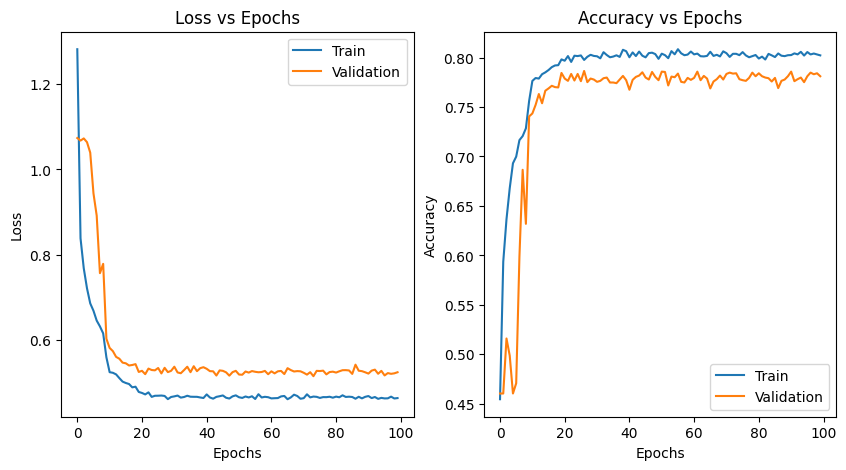

In [18]:
# Plotting loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Train')
plt.plot(range(epochs), val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, label='Train')
plt.plot(range(epochs), val_accuracies, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.show()

***Finally, we Use the model to predict emotions for each sample, and display the results as the images along with their predicted emotions:***

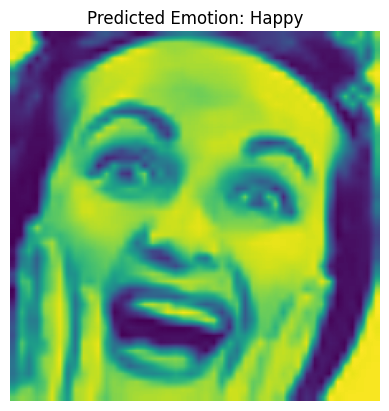

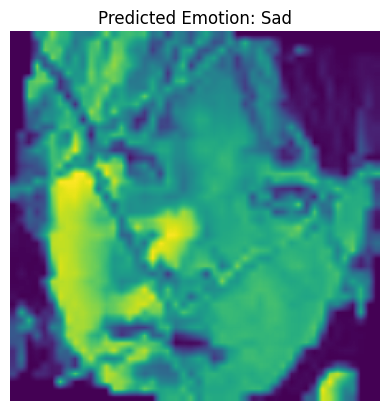

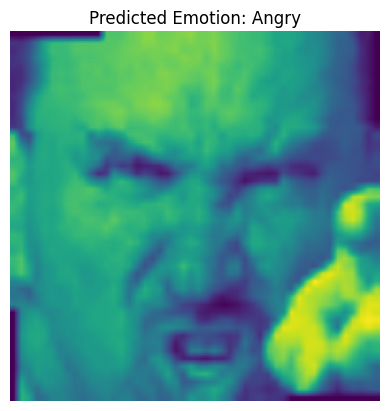

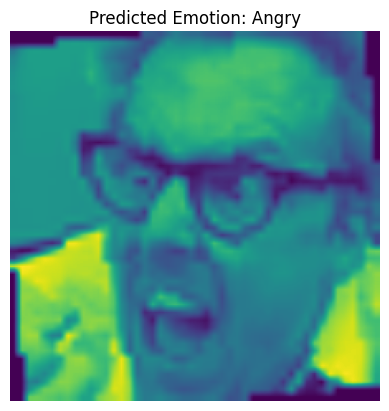

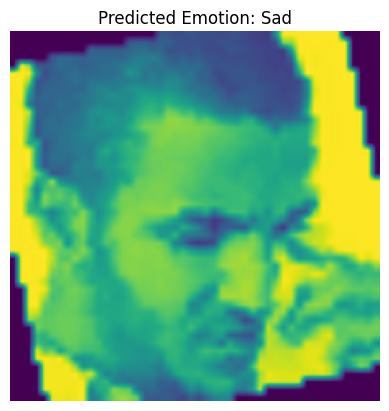

In [29]:
# Set model to evaluation mode
model.eval()

# Define emotion labels
emotion_labels = {0: 'Angry', 3: 'Happy', 4: 'Sad'}

# Function to reverse map numerical labels to original labels
reverse_mapping = {v: k for k, v in mapping.items()}

# Get 5 random samples from the test dataset
num_samples = 5
random_indices = np.random.choice(len(test_dataset), num_samples, replace=False)

# Iterate over the random indices
for idx in random_indices:
    image, label = test_dataset[idx]
    
    # Add batch dimension
    image = image.unsqueeze(0)
    
    # Move image to GPU if available
    image = image.to(device)
    
    # Perform inference
    with torch.no_grad():
        output = model(image)
    
    # Get predicted label
    _, predicted = torch.max(output, 1)
    
    # Reverse map predicted label to original label
    original_label = reverse_mapping[predicted.item()]
    
    # Convert original label to emotion
    predicted_emotion = emotion_labels[original_label]
    
    # Convert image tensor to numpy array
    image_np = image.squeeze(0).cpu().numpy()
    
    # Convert grayscale image to RGB
    # if image_np.shape[0] == 1:
    #     image_np = np.tile(image_np, (3, 1, 1))
    #     image_np = np.transpose(image_np, (1, 2, 0))
    
    # Transpose image array to (height, width, channels)
    image_np = np.transpose(image_np, (1, 2, 0))
    
    # Display the image and predicted emotion
    plt.imshow(image_np)
    plt.title(f'Predicted Emotion: {predicted_emotion}')
    plt.axis('off')
    plt.show()
